In [1]:
!pip install ultralytics

In [12]:

import shutil
def redistribuir_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    print(f"\n INICIANDO REDISTRIBUCIÓN desde: {input_dir}")

    # Extensiones de imagen a buscar
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_pairs = [] # Lista para guardar tuplas (ruta_imagen, ruta_label)

    # Recorremos las carpetas originales (train, valid, test)
    # para juntar TODAS las imágenes en un solo montón antes de repartir
    splits = ['train', 'valid', 'test']

    for split in splits:
        # Rutas esperadas según tu descripción
        img_dir = os.path.join(input_dir, split, 'images')
        lbl_dir = os.path.join(input_dir, split, 'labels')

        if not os.path.exists(img_dir):
            continue

        # Listamos todas las imágenes de esta carpeta
        files = os.listdir(img_dir)
        count_split = 0

        for f in files:
            name, ext = os.path.splitext(f)
            if ext.lower() in valid_extensions:
                img_path = os.path.join(img_dir, f)
                lbl_path = os.path.join(lbl_dir, name + ".txt")

                # Solo añadimos si existe su etiqueta correspondiente
                if os.path.exists(lbl_path):
                    all_pairs.append((img_path, lbl_path))
                    count_split += 1

        print(f"   -> Recolectadas {count_split} parejas de '{split}'")

    total_files = len(all_pairs)
    print(f" TOTAL DE PARES ENCONTRADOS: {total_files}")

    if total_files == 0:
        print(" ERROR: No se encontraron pares imagen/etiqueta. Verifica las rutas.")
        return None

    # 2. Barajamos aleatoriamente (Shuffle)
    random.shuffle(all_pairs)

    # 3. Calculamos los puntos de corte
    i_train = int(total_files * train_ratio)
    i_val = i_train + int(total_files * val_ratio)

    # Dividimos la lista
    datasets = {
        'train': all_pairs[:i_train],
        'valid': all_pairs[i_train:i_val],
        'test': all_pairs[i_val:]
    }

    # 4. Copiamos a la nueva carpeta de destino
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir) # Borramos si ya existe para empezar limpio

    print(f"\nCOPIANDO ARCHIVOS A: {output_dir} ...")

    for split, pairs in datasets.items():
        # Crear carpetas destino (ej: output/train/images)
        os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

        for img_src, lbl_src in pairs:
            # Copiar Imagen
            shutil.copy(img_src, os.path.join(output_dir, split, 'images', os.path.basename(img_src)))
            # Copiar Label
            shutil.copy(lbl_src, os.path.join(output_dir, split, 'labels', os.path.basename(lbl_src)))

        print(f"   {split.upper()}: {len(pairs)} imágenes generadas.")

    # 5. Generar el nuevo archivo data.yaml
    # Intentamos leer los nombres de las clases del yaml original
    nombres_clases = []
    yaml_orig = os.path.join(input_dir, 'data.yaml')
    if os.path.exists(yaml_orig):
        try:
            with open(yaml_orig, 'r') as f:
                d = yaml.safe_load(f)
                nombres_clases = d.get('names', [])
        except: pass

    new_yaml = {
        'path': os.path.abspath(output_dir),
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': nombres_clases,
        'nc': len(nombres_clases)
    }

    with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
        yaml.dump(new_yaml, f)

    print(f"\n PROCESO COMPLETADO. Tu nuevo dataset está en: {output_dir}")
    return output_dir

In [3]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np
from collections import Counter

def analyze_yolo_dataset(dataset_dir):


    # CARGAR CONFIGURACIÓN (CLASES)

    yaml_path = os.path.join(dataset_dir, "data.yaml")
    class_names = []

    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)
            names = data.get('names', [])
            # Normalizar si viene como diccionario o lista
            if isinstance(names, dict):
                class_names = [names[i] for i in sorted(names.keys())]
            else:
                class_names = names
        print(f" Clases detectadas: {class_names}")
    else:
        print("ADVERTENCIA: No se encontró 'data.yaml'. Se usarán IDs numéricos.")


    #  ESTADÍSTICAS Y GRÁFICAS

    print("\n Generando estadísticas...")

    # Busca etiquetas recursivamente
    label_files = glob.glob(f'{dataset_dir}/**/labels/*.txt', recursive=True)
    class_counts = Counter()

    for lfile in label_files:
        with open(lfile, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    try:
                        cls_id = int(parts[0])
                        # Si tenemos nombres, usamos el nombre, si no, el ID
                        if class_names and 0 <= cls_id < len(class_names):
                            label = class_names[cls_id]
                        else:
                            label = str(cls_id)
                        class_counts[label] += 1
                    except ValueError: pass

    if class_counts:
        # Tabla
        print(f"\n{'CLASE':<30} | {'CANTIDAD':<10}")
        print("-" * 45)
        sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
        for cls, count in sorted_items:
            print(f"{cls:<30} | {count:<10}")

        # Gráfico
        keys = [k for k, v in sorted_items]
        vals = [v for k, v in sorted_items]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=keys, y=vals, hue=keys, legend=False, palette="viridis")
        plt.title(f"Distribución de Etiquetas (Total: {sum(vals)})")
        plt.xlabel("Clase")
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    else:
        print(" No se encontraron etiquetas válidas para graficar.")

    #  VISUALIZACIÓN DE IMÁGENES

    print("\n Generando ejemplos visuales...")

    all_images = glob.glob(f'{dataset_dir}/**/images/*.jpg', recursive=True) + \
                 glob.glob(f'{dataset_dir}/**/images/*.png', recursive=True) + \
                 glob.glob(f'{dataset_dir}/**/images/*.jpeg', recursive=True)

    if all_images:
        # Tomar hasta 6 muestras aleatorias
        samples = random.sample(all_images, min(len(all_images), 6))
        plt.figure(figsize=(15, 10))

        for i, img_path in enumerate(samples):
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            # Buscar Label (Intenta ruta standard y fallback)
            label_path = img_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + ".txt"
            if not os.path.exists(label_path):
                 # Intento alternativo para estructuras anidadas
                 label_path = os.path.join(os.path.dirname(os.path.dirname(img_path)), 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + ".txt")

            box_drawn = False
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            try:
                                cls_id = int(parts[0])
                                cx, cy, bw, bh = map(float, parts[1:5])

                                x1 = int((cx - bw/2) * w)
                                y1 = int((cy - bh/2) * h)
                                x2 = int((cx + bw/2) * w)
                                y2 = int((cy + bh/2) * h)

                                color = plt.cm.tab10(cls_id % 10)
                                color_rgb = (int(color[0]*255), int(color[1]*255), int(color[2]*255))

                                cv2.rectangle(img, (x1, y1), (x2, y2), color_rgb, 3)

                                # Texto
                                if class_names and cls_id < len(class_names):
                                    label_txt = class_names[cls_id]
                                else:
                                    label_txt = str(cls_id)

                                text_y = y1 - 10 if y1 > 25 else y1 + 25
                                cv2.putText(img, label_txt, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 4)
                                cv2.putText(img, label_txt, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                                box_drawn = True
                            except ValueError: pass

            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.axis('off')

            # Nombre de la carpeta padre (train/valid/test)
            parent_folder = os.path.basename(os.path.dirname(os.path.dirname(img_path)))

            if box_drawn:
                plt.title(f"[{parent_folder}] Detectado", fontsize=10)
            else:
                plt.title(f"[{parent_folder}] Sana/Fondo", color='green', fontsize=10)

        plt.tight_layout()
        plt.show()

    else:
        print(" No se encontraron imágenes en la ruta proporcionada.")

# DATASET ROSAS

<font color ="blue">He utilizado este dataset https://app.roboflow.com/germanrv/rose-leaf-diseases-gboa4/2 , sobre enfermedades en Hojas de Rosas, el dataset tiene un tamaño de imagenes de 640 x 640 y 4 clases `Black Spot`, `	Downy Mildew` , `	Powdery Mildew` y `Normal` .

<font color ="blue">`Black Spot`(Mancha Negra) , una enfermedad fúngica que afecta comúnmente a las rosas (causada por Diplocarpon rosae) , manifestándose como manchas oscuras en hojas y frutos, debilitando las plantas y reduciendo su valor comercial.


<font color ="blue">`	Downy Mildew` ( Mildiu Velloso), una enfermedad fúngica destructiva que causa manchas amarillas en el haz de las hojas y una pelusa grisácea en el envés, afectando a cultivos como pepinos, vides, brasicáceas (brócoli, col) y rosas, favorecida por la humedad y el clima fresco.


<font color ="blue"> `	Powdery Mildew`( Oídio o Mildiu Polvoriento),es  una enfermedad fúngica que causa manchas blanquecinas polvorientas en hojas, tallos y frutos, chupando nutrientes y afectando la fotosíntesis, pudiendo llevar a la caída de hojas y a la muerte de la planta si no se controla, desarrollándose bien con calor y baja humedad, a diferencia del mildiu velloso.

<font color ="blue"> `Normal` Hoja sin enfermedad.

<font color="blue">Para saber si utilizar el dataset con o sin data augmentation, realizaré una prueba sin data augmentation, y posteriormente sin. Al observar los resultados se decidirá cual es el mas conveniente .

<font color="blue">Después de elegir el formato de dataset que queremos, se hará un torneo , es decir ejecutar varios modelos de yolo y elegir cual viene mejor para el proyecto (observando metricas como velocidad, precisión..).

## Prueba sin data Augmentation

<font color ="blue">En primer lugar , se descarga el dataset y se ve la organización de carpetas y numero de imagenes que contiene.Esto es importante para corroborar que se ha descargado correctamente.

In [4]:
import os
import glob
import yaml

"""
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("rose-leaf-diseases").project("rose-leaf-diseases")
version = project.version(14)
dataset = version.download("yolov11")
"""

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(5)
dataset = version.download("yolov11")



# ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n Descarga completada en: {dataset_dir}")

# REPORTE DE ESTRUCTURA Y CONTEO
print(f"\n REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"{carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"{carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f" TOTAL: {total_imgs} imágenes.")


#  ARREGLAR DATA.YAML

print("\n CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        #  Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        #  Ajustamos las relativas
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"    Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"    Clases: {data['names']}")

    except Exception as e:
        print(f" Error editando yaml: {e}")
else:
    print("  No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

loading Roboflow workspace...
loading Roboflow project...

 Descarga completada en: /content/rose-leaf-diseases-5

 REPORTE DEL DATASET (Carpeta: /content/rose-leaf-diseases-5)
--------------------------------------------------
TRAIN: No encontrada en /content/rose-leaf-diseases-5/train
VALID: No encontrada en /content/rose-leaf-diseases-5/valid
--------------------------------------------------
 TOTAL: 0 imágenes.

 CONFIGURACIÓN DE RUTAS (data.yaml)
  No se encontró 'data.yaml' dentro de la carpeta del dataset.

 LISTO. Para entrenar usa: data='/content/rose-leaf-diseases-5/data.yaml'


<font color ="blue"> Obsevando vemos que tiene 2735 imagenes repartidas en 1871 para train (cerca de un 70 %) , 427 para valid (15 %), 427 para test (15%). También se puede ver las 4 clases Black Spot, Downy Mildew, Normal, Powdery Mildew.

<font color ="blue"> Para poder ver mejor como se reparten las clases (el numero de patches) y poder ver ejemplos de el dataset con sus etiquetas se realiza este codigo:

In [5]:
analyze_yolo_dataset( dataset_dir)

ADVERTENCIA: No se encontró 'data.yaml'. Se usarán IDs numéricos.

 Generando estadísticas...
 No se encontraron etiquetas válidas para graficar.

 Generando ejemplos visuales...
 No se encontraron imágenes en la ruta proporcionada.


In [ ]:
#  ACTUALIZAR LIBRERÍA
!pip install ultralytics -U

import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive


# PREPARACIÓN Y CONFIGURACIÓN


# Montar Drive
if os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)
else:
    drive.mount('/content/drive')

# Definir ruta de salida en Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Rosas_NoAug"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Aseguramos que dataset_dir esté definido
if 'dataset_dir' not in locals():
    # Intento de recuperación automática
    if os.path.exists("/content/dataset_repartido"):
        dataset_dir = "/content/dataset_repartido"
        print(f" Dataset recuperado en: {dataset_dir}")
    else:
        print(" ERROR: No encuentro el dataset.")


# Arreglar data.yaml
if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    yaml_path = f"{dataset_dir}/data.yaml"

    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        data['path'] = os.path.abspath(dataset_dir)
        data['train'] = "train/images"
        data['val'] = "valid/images"
        data['test'] = "test/images"

        with open(yaml_path, 'w') as f:
            yaml.dump(data, f)
        print(" data.yaml arreglado correctamente.")
    else:
        print(" ADVERTENCIA: No se encontró data.yaml.")


#  ENTRENAMIENTO (YOLO11 MEDIUM)

if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    # Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()


    model = YOLO('yolo11m.pt')

    PROYECTO_LOCAL = 'entrenamiento_yolo11'
    NOMBRE_EJECUCION = 'yolo11m_detect_rosas_NoAug'

    try:
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,
            imgsz=640,
            batch=16,                  # Si falla, cambia a 8
            device=0 if torch.cuda.is_available() else 'cpu',
            project=PROYECTO_LOCAL,
            name=NOMBRE_EJECUCION,
            patience=10,
            plots=True
        )
        print(" Entrenamiento finalizado correctamente.")


        # GUARDAR RESULTADOS EN DRIVE

        print("\n Empaquetando y guardando resultados en Drive...")

        origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"
        destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

        if os.path.exists(destino_resultados):
            shutil.rmtree(destino_resultados)

        shutil.copytree(
            origen_resultados,
            destino_resultados,
            ignore=shutil.ignore_patterns('weights', '*.pt')
        )

        print(f" Resultados guardados en: {destino_resultados}")

    except Exception as e:
        print(f" Error durante el entrenamiento: {e}")
else:
    print(" DETENIDO: No puedo entrenar porque no encuentro el dataset (variable dataset_dir perdida al reiniciar).")

<font color="blue"> Comentar resultado

##Prueba con data Augmentation

<font color ="blue"> En este caso , utilizando las herramientas proporcionadas por roboflow, se le ha aplicado las siguientes transformaciones:


* <font color ="blue"> Flip: Horizontal, Vertical
* <font color ="blue"> 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
* <font color ="blue"> Crop: 0% Minimum Zoom, 13% Maximum Zoom
* <font color ="blue"> Rotation: Between -6° and +6°
* <font color ="blue"> Saturation: Between -12% and +12%
* <font color ="blue"> rightness: Between -15% and +15%


In [6]:
import os
import glob
import yaml

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(6)
dataset = version.download("yolov11")






# ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n Descarga completada en: {dataset_dir}")

# REPORTE DE ESTRUCTURA Y CONTEO
print(f"\n REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"{carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"{carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f" TOTAL: {total_imgs} imágenes.")


#  ARREGLAR DATA.YAML

print("\n CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        #  Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        #  Ajustamos las relativas
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"    Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"    Clases: {data['names']}")

    except Exception as e:
        print(f" Error editando yaml: {e}")
else:
    print("  No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rose-leaf-diseases-6 in yolov11:: 100%|██████████| 12946/12946 [00:02<00:00, 5395.58it/s]



 Descarga completada en: /content/rose-leaf-diseases-6

 REPORTE DEL DATASET (Carpeta: /content/rose-leaf-diseases-6)
--------------------------------------------------
TRAIN:
   └── 5613 imágenes encontradas.
VALID:
   └── 427 imágenes encontradas.
TEST:
   └── 427 imágenes encontradas.
--------------------------------------------------
 TOTAL: 6467 imágenes.

 CONFIGURACIÓN DE RUTAS (data.yaml)
    Archivo corregido: /content/rose-leaf-diseases-6/data.yaml
   (Rutas actualizadas para entrenamiento en Colab)
    Clases: ['Black Spot', 'Downy Mildew', 'Normal', 'Powdery Mildew']

 LISTO. Para entrenar usa: data='/content/rose-leaf-diseases-6/data.yaml'


<font color ="blue"> Obsevando vemos que tiene 6467 imagenes repartidas en 5613 para train (cerca de un 87 %) , 427 para valid (6,6 %), 427 para test (6,6%). También se puede ver las 4 clases Black Spot, Downy Mildew, Normal, Powdery Mildew.

In [13]:
dataset_dir_final = redistribuir_dataset(dataset_dir, "/content/dataset_repartido")


 INICIANDO REDISTRIBUCIÓN desde: /content/rose-leaf-diseases-6
   -> Recolectadas 5613 parejas de 'train'
   -> Recolectadas 427 parejas de 'valid'
   -> Recolectadas 427 parejas de 'test'
 TOTAL DE PARES ENCONTRADOS: 6467

COPIANDO ARCHIVOS A: /content/dataset_repartido ...
   TRAIN: 4526 imágenes generadas.
   VALID: 970 imágenes generadas.
   TEST: 971 imágenes generadas.

 PROCESO COMPLETADO. Tu nuevo dataset está en: /content/dataset_repartido


 Clases detectadas: ['Black Spot', 'Downy Mildew', 'Normal', 'Powdery Mildew']

 Generando estadísticas...

CLASE                          | CANTIDAD  
---------------------------------------------
Powdery Mildew                 | 7793      
Black Spot                     | 5980      
Normal                         | 1690      
Downy Mildew                   | 1593      


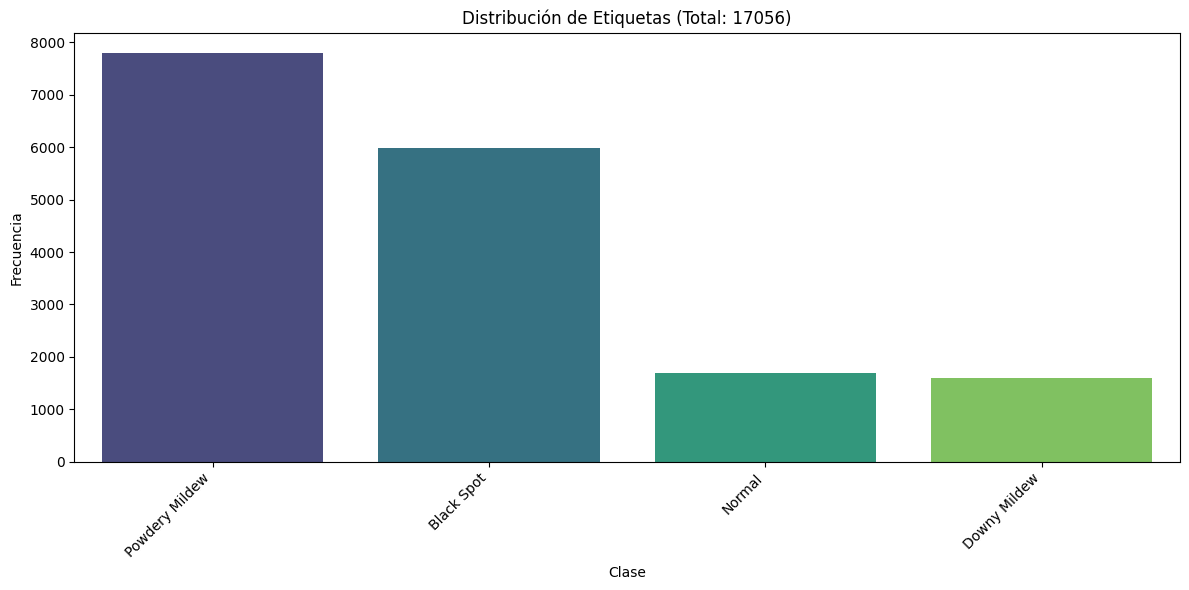


 Generando ejemplos visuales...


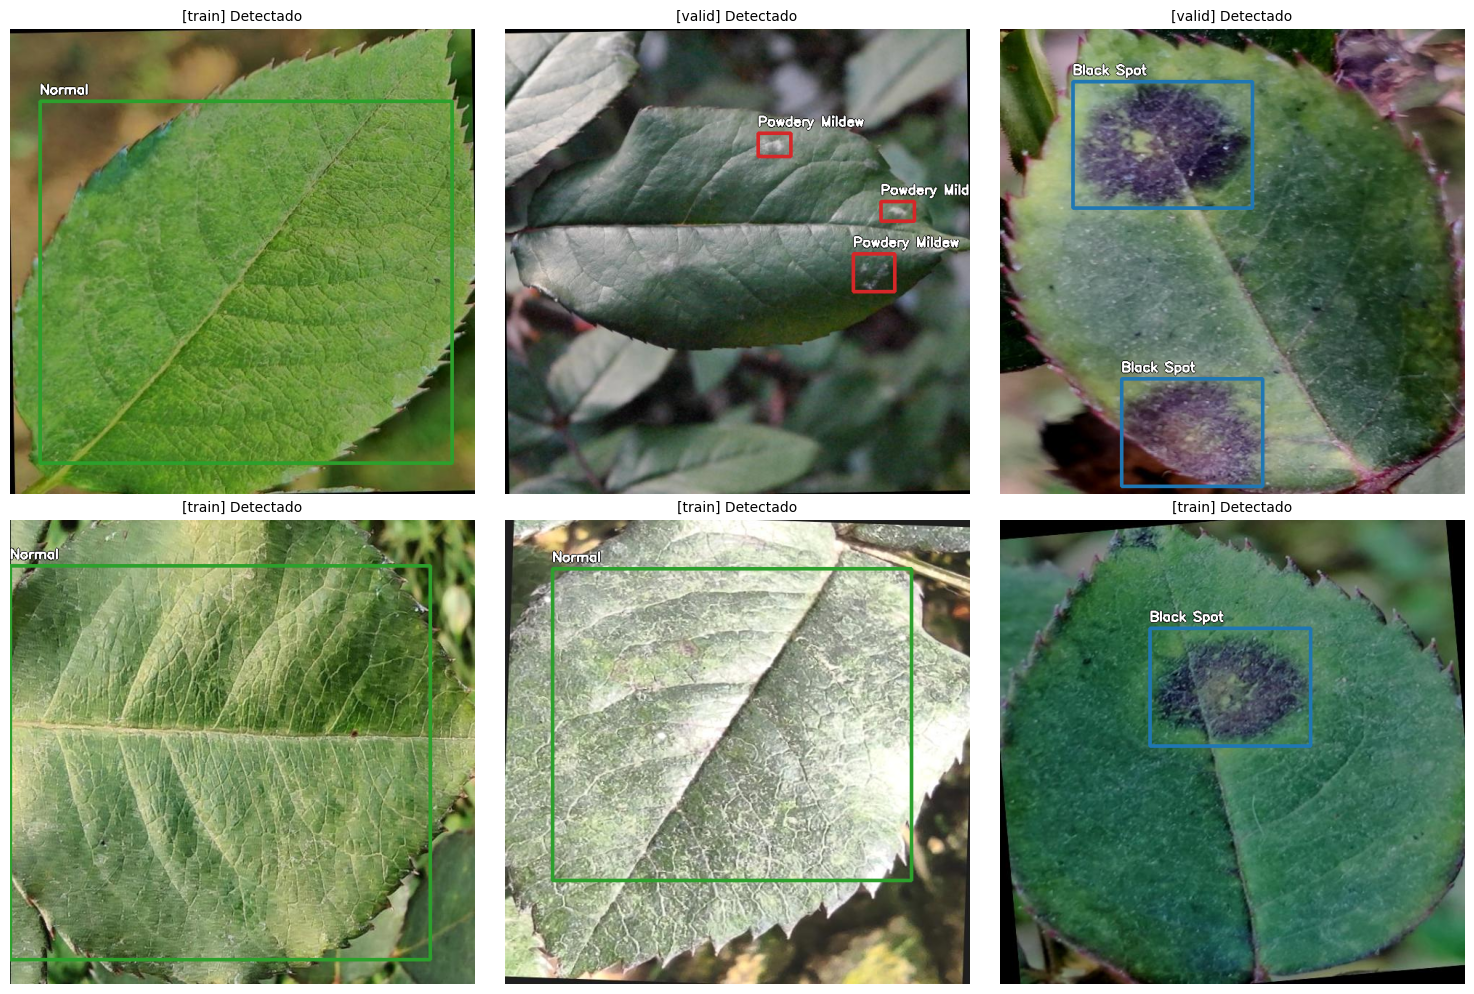

In [14]:
analyze_yolo_dataset( dataset_dir_final)

In [ ]:
#  ACTUALIZAR LIBRERÍA
!pip install ultralytics -U

import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive


# PREPARACIÓN Y CONFIGURACIÓN


# Montar Drive
if os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)
else:
    drive.mount('/content/drive')

# Definir ruta de salida en Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Rosas_Aug"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Aseguramos que dataset_dir esté definido
if 'dataset_dir' not in locals():
    # Intento de recuperación automática
    if os.path.exists("/content/dataset_repartido"):
        dataset_dir = "/content/dataset_repartido"
        print(f" Dataset recuperado en: {dataset_dir}")
    else:
        print(" ERROR: No encuentro el dataset.")


# Arreglar data.yaml
if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    yaml_path = f"{dataset_dir}/data.yaml"

    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        data['path'] = os.path.abspath(dataset_dir)
        data['train'] = "train/images"
        data['val'] = "valid/images"
        data['test'] = "test/images"

        with open(yaml_path, 'w') as f:
            yaml.dump(data, f)
        print(" data.yaml arreglado correctamente.")
    else:
        print(" ADVERTENCIA: No se encontró data.yaml.")


#  ENTRENAMIENTO (YOLO11 MEDIUM)

if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    # Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()


    model = YOLO('yolo11m.pt')

    PROYECTO_LOCAL = 'entrenamiento_yolo11'
    NOMBRE_EJECUCION = 'yolo11m_detect_rosas_Aug'

    try:
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,
            imgsz=640,
            batch=16,                  # Si falla, cambia a 8
            device=0 if torch.cuda.is_available() else 'cpu',
            project=PROYECTO_LOCAL,
            name=NOMBRE_EJECUCION,
            patience=10,
            plots=True
        )
        print(" Entrenamiento finalizado correctamente.")


        # GUARDAR RESULTADOS EN DRIVE

        print("\n Empaquetando y guardando resultados en Drive...")

        origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"
        destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

        if os.path.exists(destino_resultados):
            shutil.rmtree(destino_resultados)

        shutil.copytree(
            origen_resultados,
            destino_resultados,
            ignore=shutil.ignore_patterns('weights', '*.pt')
        )

        print(f" Resultados guardados en: {destino_resultados}")

    except Exception as e:
        print(f" Error durante el entrenamiento: {e}")
else:
    print(" DETENIDO: No puedo entrenar porque no encuentro el dataset (variable dataset_dir perdida al reiniciar).")

<font color="blue"> Comentar resultado

## Torneo mejor version Yolo

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# CONFIGURACIÓN DEL TORNEO


# . Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Ruta base del torneo en Drive
DRIVE_BASE = "/content/drive/MyDrive/Torneo_YOLO_Rosa"
os.makedirs(DRIVE_BASE, exist_ok=True)

#  Definir los contendientes (Modelos)
contendientes = [
    {"nombre": "yolov8s.pt",  "batch": 16},
    {"nombre": "yolov8m.pt",  "batch": 16},
    {"nombre": "yolov8l.pt",  "batch": 8},  # Batch reducido por seguridad
    {"nombre": "yolo11s.pt",  "batch": 16},
    {"nombre": "yolo11m.pt",  "batch": 16},
    {"nombre": "yolo11l.pt",  "batch": 8}   # Batch reducido por seguridad
]

# . Asegurar data.yaml
if 'dataset_dir' in locals():
    yaml_path = f"{dataset_dir}/data.yaml"
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
else:
    print(" ADVERTENCIA: Variable 'dataset_dir' no encontrada. Verifica la descarga.")


#  BUCLE DE COMBATE (ENTRENAMIENTO)

for i, luchador in enumerate(contendientes):
    modelo_archivo = luchador["nombre"]
    batch_size = luchador["batch"]
    nombre_combate = modelo_archivo.replace('.pt', '') # Ejemplo: yolov8s

    print("\n" + "="*60)
    print(f" RONDA {i+1}/{len(contendientes)}: Entrenando {nombre_combate} (Batch: {batch_size})")
    print("="*60)

    #  Limpieza de memoria (Fundamental en Colab)
    gc.collect()
    torch.cuda.empty_cache()

    try:
        #  Cargar modelo
        print(f"    Cargando pesos: {modelo_archivo}...")
        model = YOLO(modelo_archivo)

        #  Entrenar
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,                  # 25 épocas para el torneo
            imgsz=640,
            batch=batch_size,
            device=0 if torch.cuda.is_available() else 'cpu',
            project='Torneo_Local',     # Carpeta raíz en Colab
            name=nombre_combate,        # Subcarpeta (ej: yolov8s)
            patience=10,
            plots=True,
            verbose=True
        )
        print(f"   {nombre_combate} terminó el entrenamiento.")

        # Guardar resultados en Drive
        print(f"    Guardando estadísticas en Drive...")

        origen = f"/content/Torneo_Local/{nombre_combate}"
        destino = f"{DRIVE_BASE}/{nombre_combate}"

        if os.path.exists(destino):
            shutil.rmtree(destino)

        # Copiamos todo MENOS los pesos (.pt) para ahorrar espacio y tiempo
        shutil.copytree(
            origen,
            destino,
            ignore=shutil.ignore_patterns('weights', 'last.pt')

        )
        print(f"    Resultados de {nombre_combate} guardados.")

    except Exception as e:
        print(f"    Error entrenando {nombre_combate}: {e}")
        # Intentamos seguir con el siguiente modelo aunque este falle
        continue

print("\n" + "="*60)
print(" ¡TORNEO FINALIZADO!")
print(f" Revisa los resultados y gráficas en Drive: {DRIVE_BASE}")
print("="*60)

# DATASET patata

https://app.roboflow.com/germanrv/potatoes_leaf-diseases/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true

## Prueba sin data Augmentation

In [15]:
import os
import glob
import yaml

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(4)
dataset = version.download("yolov11")




# ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n Descarga completada en: {dataset_dir}")

# REPORTE DE ESTRUCTURA Y CONTEO
print(f"\n REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"{carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"{carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f" TOTAL: {total_imgs} imágenes.")


#  ARREGLAR DATA.YAML

print("\n CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        #  Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        #  Ajustamos las relativas
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"    Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"    Clases: {data['names']}")

    except Exception as e:
        print(f" Error editando yaml: {e}")
else:
    print("  No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-4 in yolov11:: 100%|██████████| 1636/1636 [00:00<00:00, 4491.52it/s]


 Descarga completada en: /content/Potatoes_leaf-diseases-4

 REPORTE DEL DATASET (Carpeta: /content/Potatoes_leaf-diseases-4)
--------------------------------------------------
TRAIN:
   └── 613 imágenes encontradas.
VALID:
   └── 101 imágenes encontradas.
TEST:
   └── 98 imágenes encontradas.
--------------------------------------------------
 TOTAL: 812 imágenes.

 CONFIGURACIÓN DE RUTAS (data.yaml)
    Archivo corregido: /content/Potatoes_leaf-diseases-4/data.yaml
   (Rutas actualizadas para entrenamiento en Colab)
    Clases: ['early bright', 'healthy', 'late bright']

 LISTO. Para entrenar usa: data='/content/Potatoes_leaf-diseases-4/data.yaml'


In [16]:
dataset_dir_final = redistribuir_dataset(dataset_dir, "/content/dataset_repartido")


 INICIANDO REDISTRIBUCIÓN desde: /content/Potatoes_leaf-diseases-4
   -> Recolectadas 613 parejas de 'train'
   -> Recolectadas 101 parejas de 'valid'
   -> Recolectadas 98 parejas de 'test'
 TOTAL DE PARES ENCONTRADOS: 812

COPIANDO ARCHIVOS A: /content/dataset_repartido ...
   TRAIN: 568 imágenes generadas.
   VALID: 121 imágenes generadas.
   TEST: 123 imágenes generadas.

 PROCESO COMPLETADO. Tu nuevo dataset está en: /content/dataset_repartido


 Clases detectadas: ['early bright', 'healthy', 'late bright']

 Generando estadísticas...

CLASE                          | CANTIDAD  
---------------------------------------------
early bright                   | 6354      
late bright                    | 565       
healthy                        | 152       


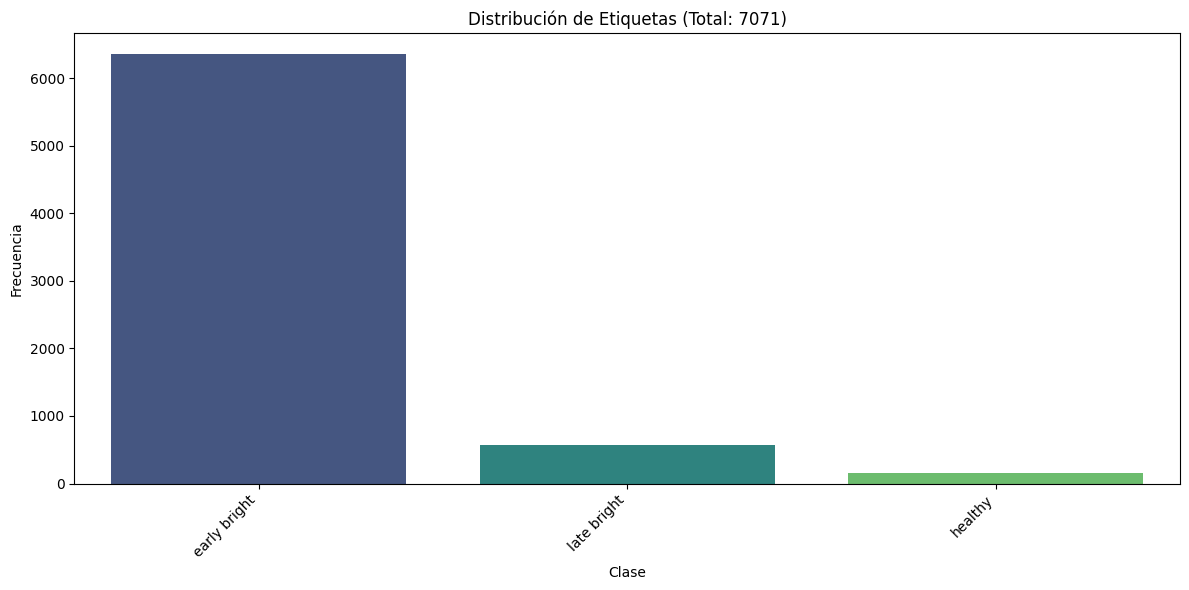


 Generando ejemplos visuales...


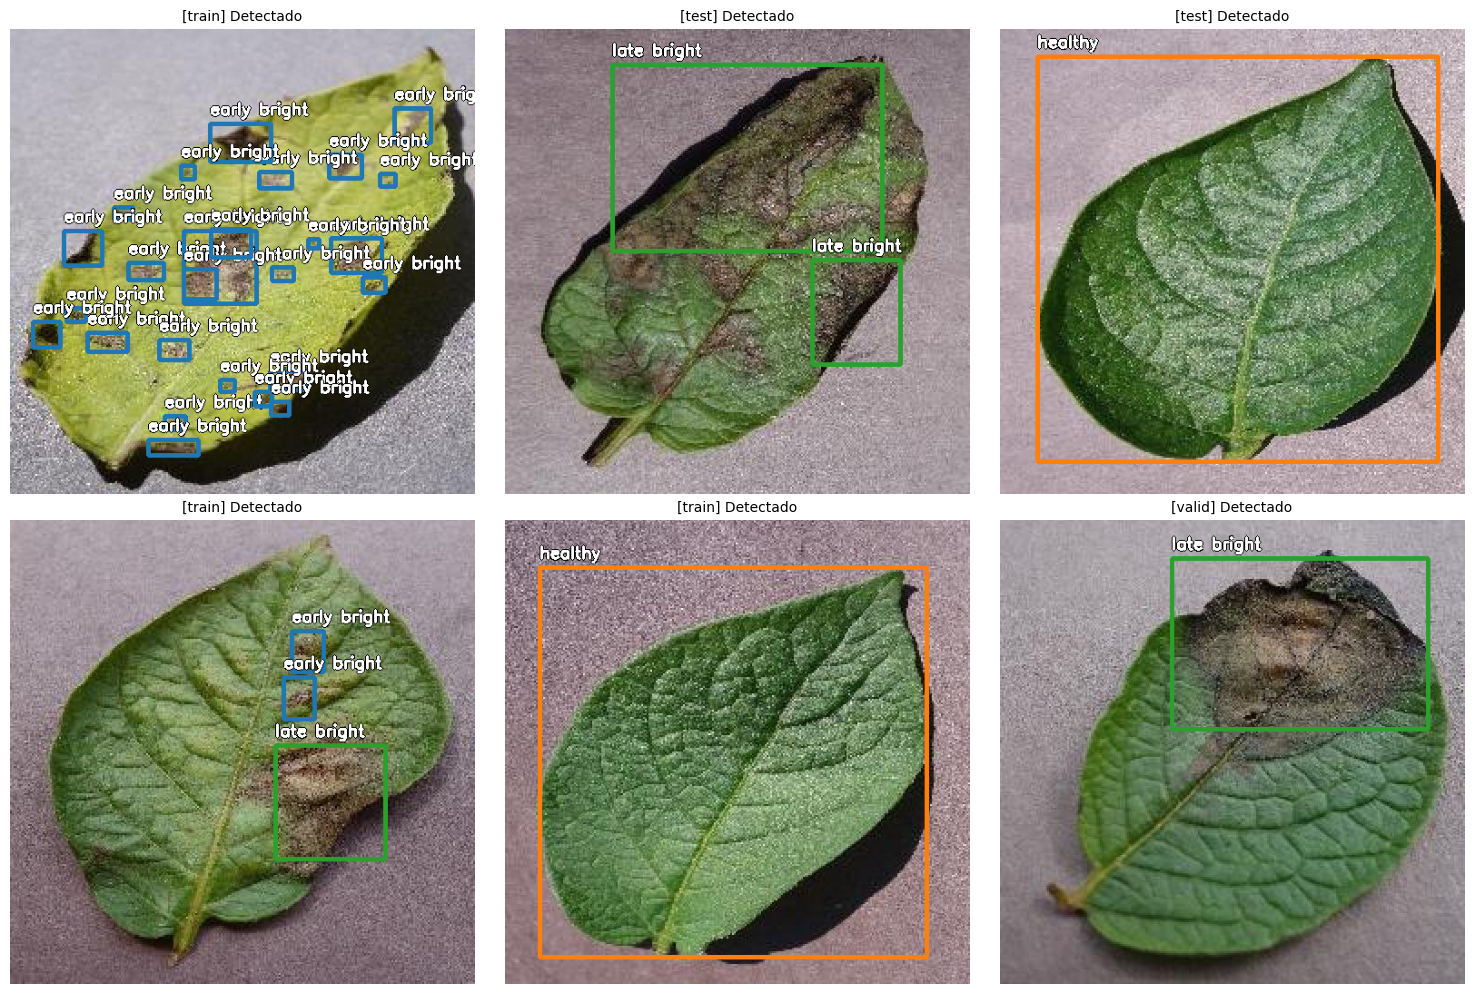

In [17]:
analyze_yolo_dataset( dataset_dir)

In [ ]:
#  ACTUALIZAR LIBRERÍA
!pip install ultralytics -U

import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive


# PREPARACIÓN Y CONFIGURACIÓN


# Montar Drive
if os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)
else:
    drive.mount('/content/drive')

# Definir ruta de salida en Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_patatas_NoAug"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Aseguramos que dataset_dir esté definido
if 'dataset_dir' not in locals():
    # Intento de recuperación automática
    if os.path.exists("/content/dataset_repartido"):
        dataset_dir = "/content/dataset_repartido"
        print(f" Dataset recuperado en: {dataset_dir}")
    else:
        print(" ERROR: No encuentro el dataset.")


# Arreglar data.yaml
if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    yaml_path = f"{dataset_dir}/data.yaml"

    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        data['path'] = os.path.abspath(dataset_dir)
        data['train'] = "train/images"
        data['val'] = "valid/images"
        data['test'] = "test/images"

        with open(yaml_path, 'w') as f:
            yaml.dump(data, f)
        print(" data.yaml arreglado correctamente.")
    else:
        print(" ADVERTENCIA: No se encontró data.yaml.")


#  ENTRENAMIENTO (YOLO11 MEDIUM)

if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    # Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()


    model = YOLO('yolo11m.pt')

    PROYECTO_LOCAL = 'entrenamiento_yolo11'
    NOMBRE_EJECUCION = 'yolo11m_detect_patatas_NoAug'

    try:
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,
            imgsz=640,
            batch=16,                  # Si falla, cambia a 8
            device=0 if torch.cuda.is_available() else 'cpu',
            project=PROYECTO_LOCAL,
            name=NOMBRE_EJECUCION,
            patience=10,
            plots=True
        )
        print(" Entrenamiento finalizado correctamente.")


        # GUARDAR RESULTADOS EN DRIVE

        print("\n Empaquetando y guardando resultados en Drive...")

        origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"
        destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

        if os.path.exists(destino_resultados):
            shutil.rmtree(destino_resultados)

        shutil.copytree(
            origen_resultados,
            destino_resultados,
            ignore=shutil.ignore_patterns('weights', '*.pt')
        )

        print(f" Resultados guardados en: {destino_resultados}")

    except Exception as e:
        print(f" Error durante el entrenamiento: {e}")
else:
    print(" DETENIDO: No puedo entrenar porque no encuentro el dataset (variable dataset_dir perdida al reiniciar).")

## Prueba con data Augmentation

In [18]:
import os
import glob
import yaml

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(3)
dataset = version.download("yolov11")





# ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n Descarga completada en: {dataset_dir}")

# REPORTE DE ESTRUCTURA Y CONTEO
print(f"\n REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"{carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"{carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f" TOTAL: {total_imgs} imágenes.")


#  ARREGLAR DATA.YAML

print("\n CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        #  Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        #  Ajustamos las relativas
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"    Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"    Clases: {data['names']}")

    except Exception as e:
        print(f" Error editando yaml: {e}")
else:
    print("  No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-3 in yolov11:: 100%|██████████| 4088/4088 [00:01<00:00, 3348.22it/s]


 Descarga completada en: /content/Potatoes_leaf-diseases-3

 REPORTE DEL DATASET (Carpeta: /content/Potatoes_leaf-diseases-3)
--------------------------------------------------
TRAIN:
   └── 1839 imágenes encontradas.
VALID:
   └── 101 imágenes encontradas.
TEST:
   └── 98 imágenes encontradas.
--------------------------------------------------
 TOTAL: 2038 imágenes.

 CONFIGURACIÓN DE RUTAS (data.yaml)
    Archivo corregido: /content/Potatoes_leaf-diseases-3/data.yaml
   (Rutas actualizadas para entrenamiento en Colab)
    Clases: ['early bright', 'healthy', 'late bright']

 LISTO. Para entrenar usa: data='/content/Potatoes_leaf-diseases-3/data.yaml'


In [19]:
dataset_dir_final = redistribuir_dataset(dataset_dir, "/content/dataset_repartido")


 INICIANDO REDISTRIBUCIÓN desde: /content/Potatoes_leaf-diseases-3
   -> Recolectadas 1839 parejas de 'train'
   -> Recolectadas 101 parejas de 'valid'
   -> Recolectadas 98 parejas de 'test'
 TOTAL DE PARES ENCONTRADOS: 2038

COPIANDO ARCHIVOS A: /content/dataset_repartido ...
   TRAIN: 1426 imágenes generadas.
   VALID: 305 imágenes generadas.
   TEST: 307 imágenes generadas.

 PROCESO COMPLETADO. Tu nuevo dataset está en: /content/dataset_repartido


 Clases detectadas: ['early bright', 'healthy', 'late bright']

 Generando estadísticas...

CLASE                          | CANTIDAD  
---------------------------------------------
early bright                   | 18068     
late bright                    | 1379      
healthy                        | 364       


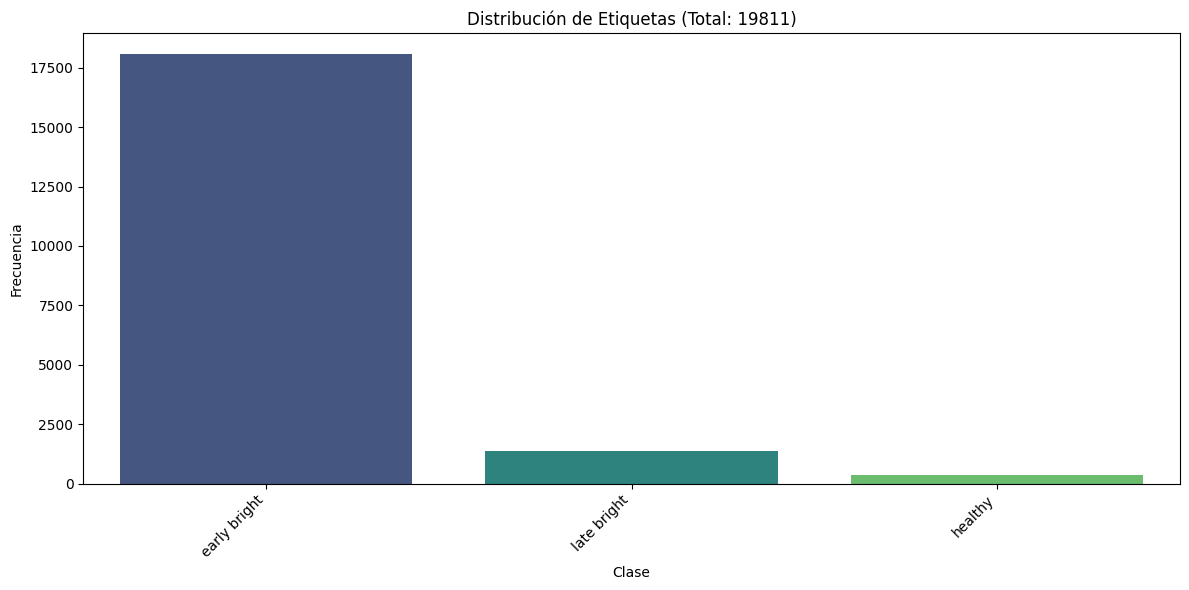


 Generando ejemplos visuales...


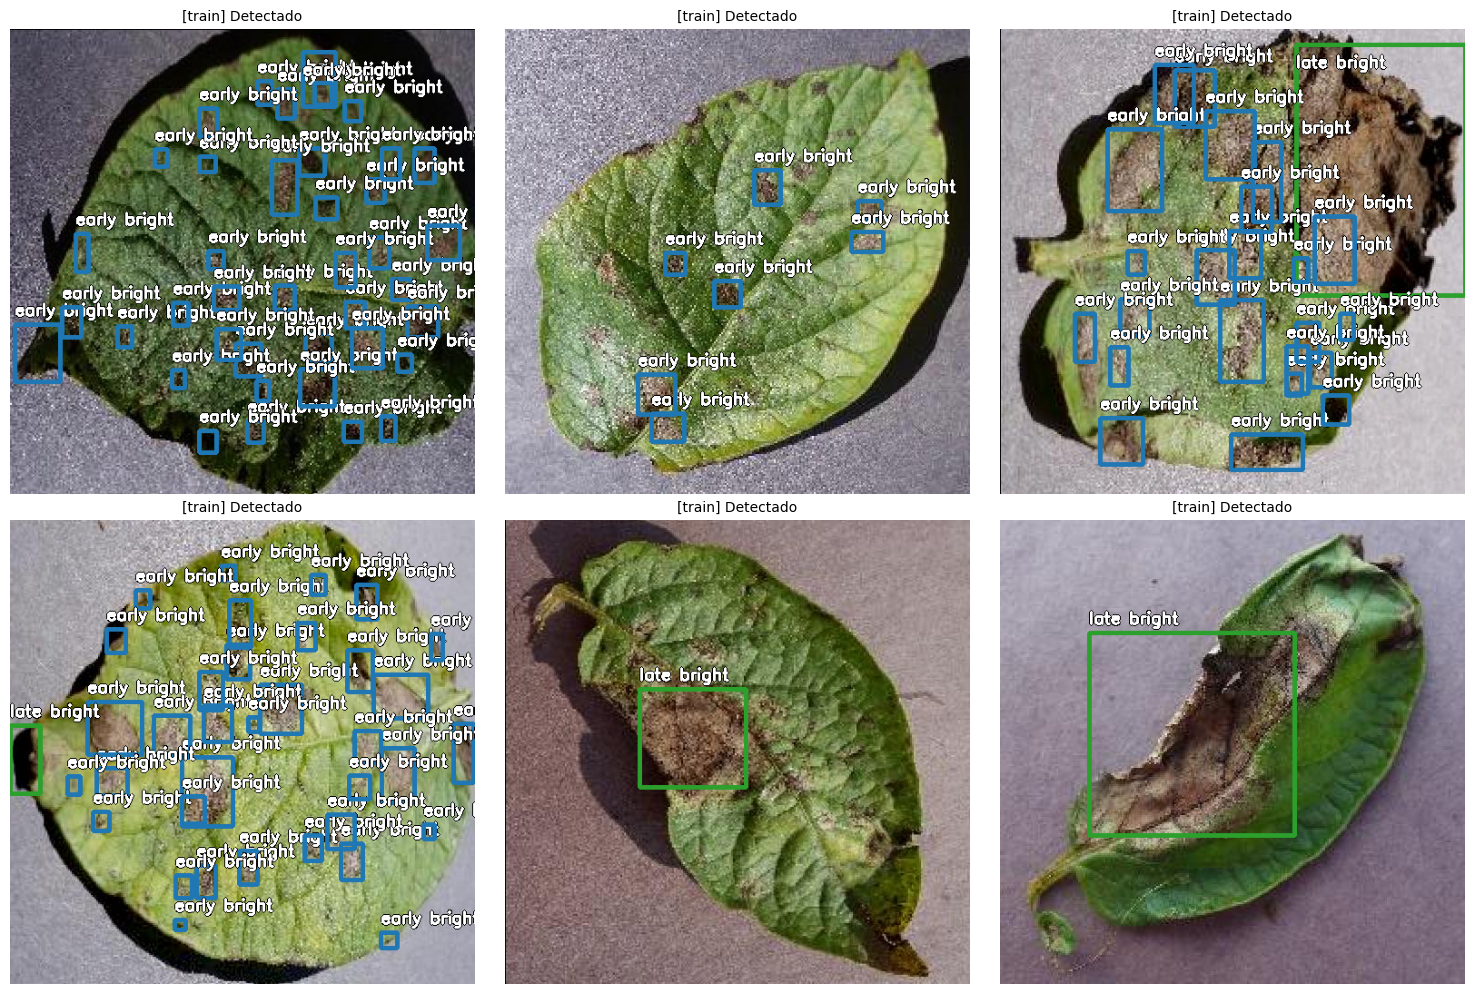

In [20]:
analyze_yolo_dataset( dataset_dir)

In [ ]:
#  ACTUALIZAR LIBRERÍA
!pip install ultralytics -U

import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive


# PREPARACIÓN Y CONFIGURACIÓN


# Montar Drive
if os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)
else:
    drive.mount('/content/drive')

# Definir ruta de salida en Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_patatas_Aug"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Aseguramos que dataset_dir esté definido
if 'dataset_dir' not in locals():
    # Intento de recuperación automática
    if os.path.exists("/content/dataset_repartido"):
        dataset_dir = "/content/dataset_repartido"
        print(f" Dataset recuperado en: {dataset_dir}")
    else:
        print(" ERROR: No encuentro el dataset.")


# Arreglar data.yaml
if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    yaml_path = f"{dataset_dir}/data.yaml"

    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        data['path'] = os.path.abspath(dataset_dir)
        data['train'] = "train/images"
        data['val'] = "valid/images"
        data['test'] = "test/images"

        with open(yaml_path, 'w') as f:
            yaml.dump(data, f)
        print(" data.yaml arreglado correctamente.")
    else:
        print(" ADVERTENCIA: No se encontró data.yaml.")


#  ENTRENAMIENTO (YOLO11 MEDIUM)

if 'dataset_dir' in locals() and os.path.exists(dataset_dir):
    # Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()


    model = YOLO('yolo11m.pt')

    PROYECTO_LOCAL = 'entrenamiento_yolo11'
    NOMBRE_EJECUCION = 'yolo11m_detect_patatas_Aug'

    try:
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,
            imgsz=640,
            batch=16,                  # Si falla, cambia a 8
            device=0 if torch.cuda.is_available() else 'cpu',
            project=PROYECTO_LOCAL,
            name=NOMBRE_EJECUCION,
            patience=10,
            plots=True
        )
        print(" Entrenamiento finalizado correctamente.")


        # GUARDAR RESULTADOS EN DRIVE

        print("\n Empaquetando y guardando resultados en Drive...")

        origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"
        destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

        if os.path.exists(destino_resultados):
            shutil.rmtree(destino_resultados)

        shutil.copytree(
            origen_resultados,
            destino_resultados,
            ignore=shutil.ignore_patterns('weights', '*.pt')
        )

        print(f" Resultados guardados en: {destino_resultados}")

    except Exception as e:
        print(f" Error durante el entrenamiento: {e}")
else:
    print(" DETENIDO: No puedo entrenar porque no encuentro el dataset (variable dataset_dir perdida al reiniciar).")